In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os, sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
os.chdir('/Users/walu/mdwarfs/ae_classifier/')
sys.path.append('/Users/walu/mdwarfs/ae_classifier/network_architecture/ae_models')
sys.path.append('/Users/walu/mdwarfs/ae_classifier/network_architecture/classifier_models')
from trainer import AEClassifierTrainer
from early_stopping import EarlyStopping
from direct_composite_beta import Autoencoder_Classifier
import data_processor as dp
from torch.optim.lr_scheduler import CyclicLR
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from save_recon_plots import save_recon_plots

In [2]:


def generate_fake_dataset(save_path="fake_dataset.csv"):
    np.random.seed(42)

    num_samples = 1000
    signal_length = 1024
    time = np.linspace(0, 1, signal_length)

    class_components = {
        'class_1': 1,
        'class_2': 2,
        'class_3': 3, 
        'class_4': 4,
        'class_5': 5
    }

    labels = list(class_components.keys())

    signal_data = []
    tic_ids = []
    signal_labels = []

    for i in range(num_samples):
        label_idx = i % len(labels)
        label = labels[label_idx]
        num_freqs = class_components[label]

        # Sum of multiple sinusoids
        signal = np.zeros_like(time)
        for _ in range(num_freqs):
            freq = np.random.uniform(0, 100)
            signal += np.sin(2 * np.pi * freq * time)

        # Add Gaussian noise
        noise = np.random.normal(0, 0.1, signal_length)
        signal += noise

        tic_id = np.random.randint(10000, 99999)

        signal_data.append(signal)
        tic_ids.append(tic_id)
        signal_labels.append(label)

    # Convert to numpy arrays
    signal_data = np.array(signal_data)
    tic_ids = np.array(tic_ids).reshape(-1, 1)
    signal_labels = np.array(signal_labels).reshape(-1, 1)

    # Combine all into one DataFrame
    data = np.hstack((signal_data, tic_ids, signal_labels))

    # Create column names for the DataFrame
    columns = [f"point_{i}" for i in range(signal_length)] + ['TIC', 'label']

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)

    # Save to CSV
    df.to_csv(save_path, index=False)
    print(f"Dataset saved to {save_path} with shape: {df.shape}")



# Call the function to generate and save the dataset
generate_fake_dataset("fake_sinusoidal_dataset.csv")

#dpc = dp.DataProcessing('fake_sinusoidal_dataset.csv', input_dataset_shape=1024)
#train_data, train_labels, tic_train = dpc.get_train_set()
#val_data, val_labels, tic_val = dpc.get_validation_set()
#print(f"Train data shape: {train_data.shape}")
#print(f"Train labels shape: {train_labels.shape}")
#print(f"Validation data shape: {val_data.shape}")
#print(f"Validation labels shape: {val_labels.shape}")

Dataset saved to fake_sinusoidal_dataset.csv with shape: (1000, 1026)


In [2]:
dpc = dp.DataProcessing('../training_data/PULS_NonPULS_unbalanced.csv', input_dataset_shape=1024)
train_data, train_labels, tic_train = dpc.get_train_set()
val_data, val_labels, tic_val = dpc.get_validation_set()
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Shape of loaded data: (51396, 1026)
Label Mapping:
'NonPULS' -> 0
'PULS' -> 1
Input shape: 1024
Train set size: 35977
Validation set size: 15419
Number of classes: 2
Data processing completed.
Train data shape: torch.Size([35977, 1, 1024])
Train labels shape: torch.Size([35977])
Validation data shape: torch.Size([15419, 1, 1024])
Validation labels shape: torch.Size([15419])


In [3]:
"""
writing a sample program to train on
sample dataset
"""
batch_size = 128
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [7]:
df = pd.read_csv('fake_sinusoidal_dataset.csv')
df.shape

(100000, 1026)

In [31]:



model_mlp = MLP_classifier(in_shape=dpc.get_input_size(), dense_shape=512, out_shape=len(dpc.get_label_mapping()))
model_mlp.train()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mlp.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)
num_epochs = 2000
for epoch in range(num_epochs):
    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_data = batch_data.view(batch_data.size(0), -1)  # Flatten the input
        optimizer.zero_grad()
        outputs = model_mlp(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/2000], Loss: 0.5531
Epoch [2/2000], Loss: 0.4790
Epoch [3/2000], Loss: 0.3920
Epoch [4/2000], Loss: 0.3671
Epoch [5/2000], Loss: 0.3532
Epoch [6/2000], Loss: 0.3143
Epoch [7/2000], Loss: 0.3616
Epoch [8/2000], Loss: 0.3625
Epoch [9/2000], Loss: 0.3158
Epoch [10/2000], Loss: 0.2613
Epoch [11/2000], Loss: 0.2609
Epoch [12/2000], Loss: 0.2548
Epoch [13/2000], Loss: 0.2766
Epoch [14/2000], Loss: 0.2814
Epoch [15/2000], Loss: 0.2474
Epoch [16/2000], Loss: 0.2081
Epoch [17/2000], Loss: 0.2635
Epoch [18/2000], Loss: 0.2006
Epoch [19/2000], Loss: 0.1743
Epoch [20/2000], Loss: 0.1889
Epoch [21/2000], Loss: 0.1662
Epoch [22/2000], Loss: 0.1672
Epoch [23/2000], Loss: 0.2033
Epoch [24/2000], Loss: 0.1456
Epoch [25/2000], Loss: 0.1683
Epoch [26/2000], Loss: 0.2398
Epoch [27/2000], Loss: 0.1592
Epoch [28/2000], Loss: 0.1570
Epoch [29/2000], Loss: 0.1400
Epoch [30/2000], Loss: 0.1156
Epoch [31/2000], Loss: 0.1234
Epoch [32/2000], Loss: 0.1386
Epoch [33/2000], Loss: 0.1713
Epoch [34/2000], Lo

KeyboardInterrupt: 

In [73]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_data, batch_labels in val_loader:
        batch_data = batch_data.to(device)
        batch_data = batch_data.view(batch_data.size(0), -1) #flatten the input
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

In [74]:
correct / total
# Output the accuracy
print(f'Accuracy of the model on the validation set: {100 * correct / total:.2f}%')
# Save the model

Accuracy of the model on the validation set: 99.50%


In [4]:
#defining a weight initializer with kaiming normal
def initialize_weights_kaiming_normal(model, a=0.1):  # 'a' = LeakyReLU negative_slope
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu', a=a)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [16]:
model = ae_classifier_combined.autoencoder_classifier(ae_model='nets_1024', classifier_model ='mlp', output_shape=len(dpc.get_label_mapping()))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=.01, step_size_up = 3000, mode='triangular')
recon_loss_fn = nn.MSELoss()
#recon_loss_fn = nn.L1Loss()
class_loss_fn = nn.CrossEntropyLoss()
#initializing weights using kaiming normal
#initialize_weights_kaiming_normal(model, a = 0.1)
#set_seed(42)

selected encdoder: bens_cubic_code(
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 32))
  (en_layer1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_layer2): Sequential(
    (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_layer3): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_layer4): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_

In [5]:
model = Autoencoder_Classifier(classifier_type= 'direct classifier', ae_model='nets_1024', classifier_model ='binary_classifier', output_shape=len(dpc.get_label_mapping()))
optimizer = optim.Adam(model.parameters(), lr=.5e-4)
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=.01, step_size_up = 3000, mode='triangular')
recon_loss_fn = nn.MSELoss()
#recon_loss_fn = nn.L1Loss()
class_loss_fn = nn.BCEWithLogitsLoss()
initialize_weights_kaiming_normal(model, a = 0.1)
set_seed(42)

KeyError: 'binary_classifier'

In [48]:
train_recon_losses = []
train_class_losses = []
val_recon_losses = []
val_class_losses = []

def compute_accuracy(logits, labels, binary_class=True):
    if binary_class:
        # Apply sigmoid and threshold
        probs = torch.sigmoid(logits)
        predicted_classes = (probs > 0.5).long()
    else:
        predicted_classes = torch.argmax(logits, dim=1)

    correct = (predicted_classes == labels.long()).sum().item()
    return correct, predicted_classes


In [8]:

num_epochs = 500
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_recon_loss = 0
    train_class_loss = 0
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        reconstruction, class_logits = model(batch_data)

        recon_loss = recon_loss_fn(reconstruction, batch_data)
        class_loss = class_loss_fn(class_logits, batch_labels)
        total_loss = recon_loss + class_loss

        total_loss.backward()
        optimizer.step()
        #scheduler.step()


        train_recon_loss += recon_loss.item()
        train_class_loss += class_loss.item()

    train_recon_loss /= len(train_loader)
    train_class_loss /= len(train_loader)
    train_recon_losses.append(train_recon_loss)
    train_class_losses.append(train_class_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {train_recon_loss:.4f}, Class Loss: {train_class_loss:.4f}")



Epoch [1/500], Recon Loss: 1.4510, Class Loss: 1.3026
Epoch [2/500], Recon Loss: 1.4208, Class Loss: 1.2902
Epoch [3/500], Recon Loss: 1.3934, Class Loss: 1.2955
Epoch [4/500], Recon Loss: 1.3646, Class Loss: 1.2804
Epoch [5/500], Recon Loss: 1.3361, Class Loss: 1.2706
Epoch [6/500], Recon Loss: 1.3074, Class Loss: 1.2603
Epoch [7/500], Recon Loss: 1.2816, Class Loss: 1.2595
Epoch [8/500], Recon Loss: 1.2566, Class Loss: 1.2571
Epoch [9/500], Recon Loss: 1.2335, Class Loss: 1.2456
Epoch [10/500], Recon Loss: 1.2143, Class Loss: 1.2372
Epoch [11/500], Recon Loss: 1.1955, Class Loss: 1.2283
Epoch [12/500], Recon Loss: 1.1781, Class Loss: 1.2265
Epoch [13/500], Recon Loss: 1.1648, Class Loss: 1.2294
Epoch [14/500], Recon Loss: 1.1522, Class Loss: 1.2296
Epoch [15/500], Recon Loss: 1.1397, Class Loss: 1.2112
Epoch [16/500], Recon Loss: 1.1313, Class Loss: 1.2082
Epoch [17/500], Recon Loss: 1.1213, Class Loss: 1.2061
Epoch [18/500], Recon Loss: 1.1145, Class Loss: 1.1993
Epoch [19/500], Rec

KeyboardInterrupt: 

In [30]:
#Loading saved model
model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [31]:
model.eval()
val_recon_loss = 0
val_class_loss = 0
val_correct = 0
total_val = 0
all_predicted = []
all_true_labels = []
binary_class = True

with torch.no_grad():
    for batch_data, batch_labels in val_loader:
        if binary_class:
            batch_labels = batch_labels.float()

        if model.classifier_type == 'direct classifier':
            class_logits = model(batch_data)
        else:
            reconstruction, class_logits = model(batch_data)
            recon_loss = recon_loss_fn(reconstruction, batch_data)
            val_recon_loss += recon_loss.item()

        class_loss = class_loss_fn(class_logits, batch_labels)
        val_class_loss += class_loss.item()

        val_correct += compute_accuracy(class_logits, batch_labels)
        total_val += batch_labels.size(0)

        # Store predictions and true labels
        if binary_class:
            preds = (torch.sigmoid(class_logits) >= 0.5).long()
        else:
            preds = torch.argmax(class_logits, dim=1)

        all_predicted.append(preds)
        all_true_labels.append(batch_labels)

# Average losses
if model.classifier_type == 'composite classifier':
    val_recon_loss /= len(val_loader)
    val_recon_losses.append(val_recon_loss)
else:
    val_recon_loss = None  # Optional: or skip recording

val_class_loss /= len(val_loader)
val_class_losses.append(val_class_loss)

# Final accuracy print
print(f"accuracy: {val_correct / total_val:.4f}")

# Stack predictions and labels for metrics
all_predicted = torch.cat(all_predicted).cpu().numpy()
all_true_labels = torch.cat(all_true_labels).cpu().numpy()



accuracy: 0.5725


In [83]:
"""
Different Version of the training loop
It also has validation for each epoch to
diagnose overfitting
"""
train_recon_losses = []
train_class_losses = []
val_recon_losses = []
val_class_losses = []
val_accuracies = []

all_predicted = []
all_true_labels = []

num_epochs = 500
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_recon_loss = 0
    train_class_loss = 0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        reconstruction, class_logits = model(batch_data)

        recon_loss = recon_loss_fn(reconstruction, batch_data)
        class_loss = class_loss_fn(class_logits, batch_labels)
        total_loss = 0.3 * recon_loss + 0.7 * class_loss

        total_loss.backward()
        optimizer.step()
        # scheduler.step()

        train_recon_loss += recon_loss.item()
        train_class_loss += class_loss.item()

    train_recon_loss /= len(train_loader)
    train_class_loss /= len(train_loader)

    train_recon_losses.append(train_recon_loss)
    train_class_losses.append(train_class_loss)

    # --- Validation ---
    model.eval()
    val_recon_loss = 0
    val_class_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            reconstruction, class_logits = model(batch_data)

            recon_loss = recon_loss_fn(reconstruction, batch_data)
            class_loss = class_loss_fn(class_logits, batch_labels)

            val_recon_loss += recon_loss.item()
            val_class_loss += class_loss.item()
            val_correct += compute_accuracy(class_logits, batch_labels)
            total_val += batch_labels.size(0)
            

    val_recon_loss /= len(val_loader)
    val_class_loss /= len(val_loader)
    val_accuracy = val_correct / total_val
    val_accuracies.append(val_accuracy)

    val_recon_losses.append(val_recon_loss)
    val_class_losses.append(val_class_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Recon Loss: {train_recon_loss:.4f}, Train Class Loss: {train_class_loss:.4f}, "
          f"Val Recon Loss: {val_recon_loss:.4f}, Val Class Loss: {val_class_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")



Epoch [1/500], Train Recon Loss: 1.1657, Train Class Loss: 1.7985, Val Recon Loss: 1.1666, Val Class Loss: 1.7586, Val Accuracy: 0.1690
Epoch [2/500], Train Recon Loss: 1.1637, Train Class Loss: 1.7469, Val Recon Loss: 1.1649, Val Class Loss: 1.7239, Val Accuracy: 0.1770
Epoch [3/500], Train Recon Loss: 1.1618, Train Class Loss: 1.7135, Val Recon Loss: 1.1640, Val Class Loss: 1.7029, Val Accuracy: 0.1887
Epoch [4/500], Train Recon Loss: 1.1598, Train Class Loss: 1.6998, Val Recon Loss: 1.1638, Val Class Loss: 1.7006, Val Accuracy: 0.1803
Epoch [5/500], Train Recon Loss: 1.1583, Train Class Loss: 1.6918, Val Recon Loss: 1.1593, Val Class Loss: 1.6826, Val Accuracy: 0.1957
Epoch [6/500], Train Recon Loss: 1.1570, Train Class Loss: 1.6836, Val Recon Loss: 1.1605, Val Class Loss: 1.6759, Val Accuracy: 0.1803
Epoch [7/500], Train Recon Loss: 1.1560, Train Class Loss: 1.6721, Val Recon Loss: 1.1585, Val Class Loss: 1.6731, Val Accuracy: 0.1923
Epoch [8/500], Train Recon Loss: 1.1550, Train C

In [49]:
train_recon_losses = []
train_class_losses = []
val_recon_losses = []
val_class_losses = []
val_accuracies = []

binary_class = True  # <<-- Set this depending on your classification task

early_stopping = EarlyStopping(patience=100, min_delta=1e-3)
best_val_accuracy = 0.0

num_epochs = 1000
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_recon_loss = 0
    train_class_loss = 0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()

        if binary_class:
            batch_labels = batch_labels.float()

        if model.classifier_type == 'direct classifier':
            class_logits = model(batch_data)
            class_loss = class_loss_fn(class_logits, batch_labels)
            total_loss = class_loss
            train_class_loss += class_loss.item()

        else:
            reconstruction, class_logits = model(batch_data)
            recon_loss = recon_loss_fn(reconstruction, batch_data)
            class_loss = class_loss_fn(class_logits, batch_labels)
            total_loss = recon_loss + class_loss
            train_recon_loss += recon_loss.item()
            train_class_loss += class_loss.item()

        total_loss.backward()
        optimizer.step()

    if model.classifier_type == 'composite classifier':
        train_recon_loss /= len(train_loader)
        train_recon_losses.append(train_recon_loss)
    else:
        train_recon_loss = None

    train_class_loss /= len(train_loader)
    train_class_losses.append(train_class_loss)

    # --- Validation ---
    model.eval()
    val_recon_loss = 0
    val_class_loss = 0
    logits = []
    all_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            if binary_class:
                batch_labels = batch_labels.float()

            if model.classifier_type == 'direct classifier':
                class_logits = model(batch_data)
            else:
                reconstruction, class_logits = model(batch_data)
                recon_loss = recon_loss_fn(reconstruction, batch_data)
                val_recon_loss += recon_loss.item()

            logits.append(class_logits)
            all_labels.append(batch_labels)

    logits = torch.cat(logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    val_accuracy = compute_accuracy(logits, all_labels)
    val_class_loss = class_loss_fn(logits, all_labels)
    val_class_losses.append(val_class_loss.item())

    if model.classifier_type == 'composite classifier':
        val_recon_loss /= len(val_loader)
        val_recon_losses.append(val_recon_loss)
        val_loss = val_recon_loss + val_class_loss
    else:
        val_recon_loss = None
        val_loss = val_class_loss

    # ✅ Save best model first
    best_val_accuracy = early_stopping.save_best_checkpoint(
        model, val_accuracy, best_val_accuracy, path='best_model.pt'
    )

    # Then check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    # --- Logging
    if model.classifier_type == 'composite classifier':
        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Recon Loss: {train_recon_loss:.4f}, "
            f"Train Class Loss: {train_class_loss:.4f}, "
            f"Val Recon Loss: {val_recon_loss:.4f}, "
            f"Val Class Loss: {val_class_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.4f}"
        )
    else:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Class Loss: {train_class_loss:.4f}, "
            f"Val Class Loss: {val_class_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.4f}"
        )


Epoch [1/1000], Train Class Loss: 1.4510, Val Class Loss: 1.4186, Val Accuracy: 0.3097
Epoch [2/1000], Train Class Loss: 1.4106, Val Class Loss: 1.3885, Val Accuracy: 0.3248
Epoch [3/1000], Train Class Loss: 1.3831, Val Class Loss: 1.3753, Val Accuracy: 0.3329
Epoch [4/1000], Train Class Loss: 1.3620, Val Class Loss: 1.3073, Val Accuracy: 0.3938
Epoch [5/1000], Train Class Loss: 1.3439, Val Class Loss: 1.3549, Val Accuracy: 0.3488
Epoch [6/1000], Train Class Loss: 1.3289, Val Class Loss: 1.2998, Val Accuracy: 0.3984
Epoch [7/1000], Train Class Loss: 1.3164, Val Class Loss: 1.3217, Val Accuracy: 0.3819
Epoch [8/1000], Train Class Loss: 1.3495, Val Class Loss: 1.5622, Val Accuracy: 0.1793
Epoch [9/1000], Train Class Loss: 1.4826, Val Class Loss: 1.4134, Val Accuracy: 0.2831
Epoch [10/1000], Train Class Loss: 1.3781, Val Class Loss: 1.3622, Val Accuracy: 0.3329
Epoch [11/1000], Train Class Loss: 1.3314, Val Class Loss: 1.3142, Val Accuracy: 0.3974
Epoch [12/1000], Train Class Loss: 1.2880

KeyboardInterrupt: 

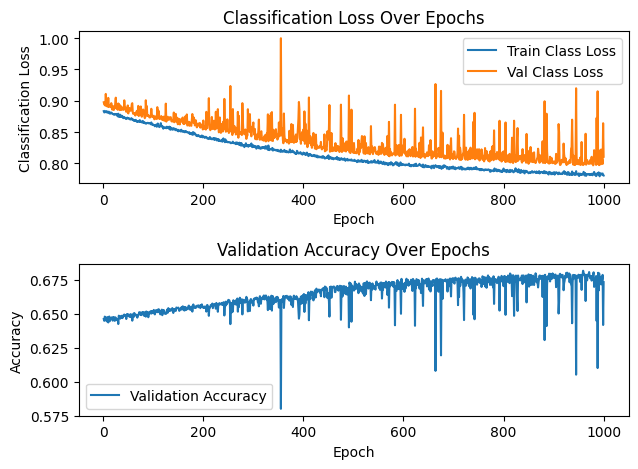

In [18]:
"""
Print training vs validation
loss
"""
import matplotlib.pyplot as plt
import numpy as np
epochs = range(1, num_epochs + 1)
#epochs = range(1, 551+1)

# Plot classification loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_class_losses, label='Train Class Loss')
plt.plot(epochs, val_class_losses, label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.legend()

#Plot Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
"""
Print training vs validation
loss
"""
import matplotlib.pyplot as plt
import numpy as np
epochs = range(1, num_epochs + 1)
#epochs = range(1, 551+1)

plt.figure(figsize=(12, 5))

# Plot reconstruction loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_recon_losses, label='Train Recon Loss')
plt.plot(epochs, val_recon_losses, label='Val Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.legend()

# Plot classification loss
plt.subplot(2, 2, 2)
plt.plot(epochs, train_class_losses, label='Train Class Loss')
plt.plot(epochs, val_class_losses, label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.legend()

#Plot Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

#Plot total loss
plt.subplot(2, 2, 4)
plt.plot(epochs, np.array(train_recon_losses) + np.array(train_class_losses), label='Train Total Loss')
plt.plot(epochs, np.array(val_recon_losses) + np.array(val_class_losses), label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'num_epochs' is not defined

In [3]:
"""
Testing trainer class
"""
trainer = AEClassifierTrainer(
    data_processor= dpc,
    ae_model = 'nets_1024',
    classifier_model = 'mlp',
    model_id = 'beta_testing',
    batch_size = 64,
    num_epochs = 10,
    lr = 1e-3,
    scheduler_type = None,
    leaky_relu_a= 0.1,
    min_delta = 1e-1,
    patience = 100,
    save_val_recons= True
)
#trainer.train_and_validate()

selected encdoder: bens_cubic_code(
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 32))
  (en_layer1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_layer2): Sequential(
    (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_layer3): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_layer4): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (en_

<Figure size 800x600 with 0 Axes>

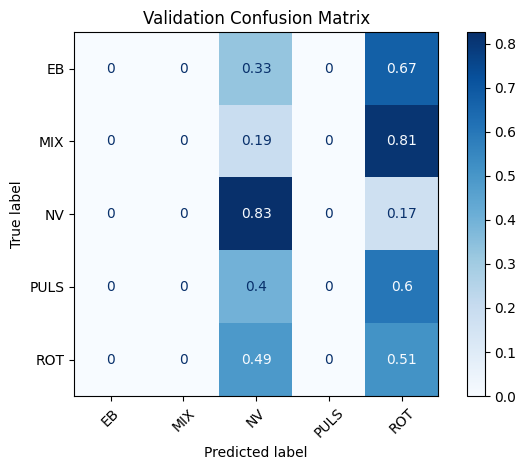

In [32]:
"""
Plotting Confusion Matrix
"""
# Reverse the label mapping: int -> string
index_to_classname = {idx: name for idx, name in dpc.get_label_mapping().items()}

# Create class names list in correct order
class_names = [index_to_classname[i] for i in range(len(index_to_classname))]

cm = confusion_matrix(all_true_labels, all_predicted, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()



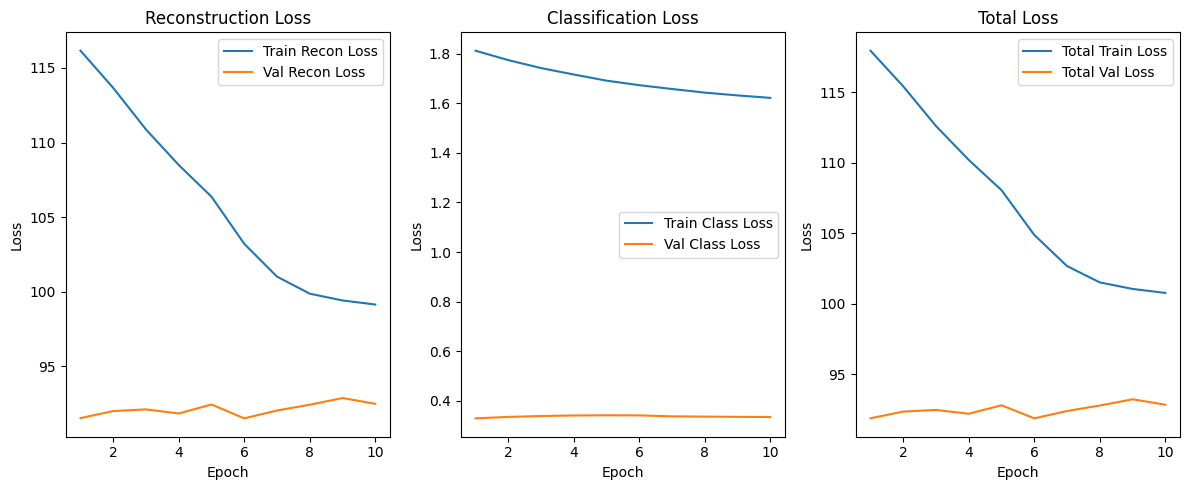

In [4]:
trainer.plot_losses()

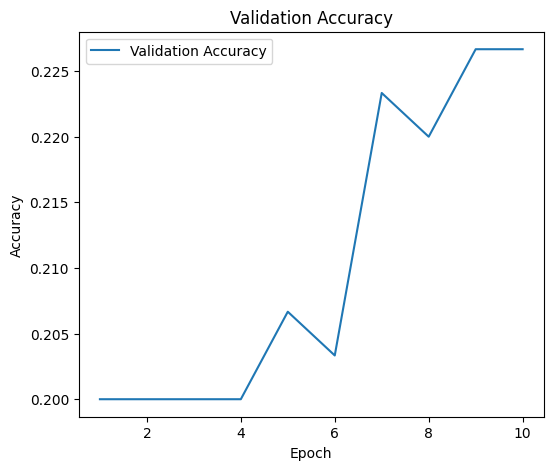

In [5]:
trainer.plot_accuracy()

<Figure size 800x600 with 0 Axes>

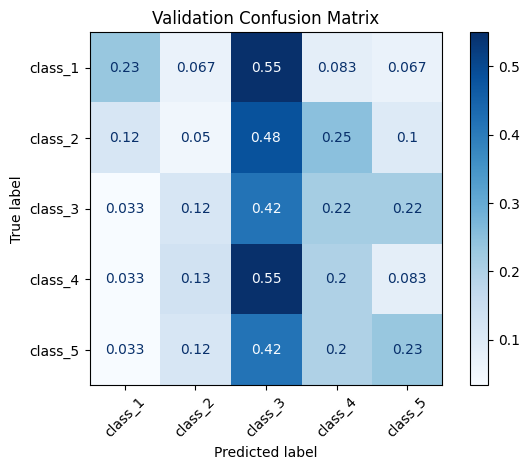

In [6]:
trainer.plot_confusion_matrix()

In [4]:
trainer.load_best_model('../best_trained_models/best_model_balona_balancedsample4.pt')
trainer._validate()

Loaded model from ../best_trained_models/best_model_balona_balancedsample4.pt


{'val_recon_loss': 0.8125274602426301,
 'val_class_loss': tensor(0.0078),
 'val_accuracy': 0.6663312248418631}

In [11]:
df = pd.read_csv('model_beta_testing/val_originals_and_reconstructions.csv')
originals = df[df['type'] == 'original'].drop(columns='type').reset_index(drop=True)
recons = df[df['type'] == 'reconstruction'].drop(columns='type').reset_index(drop=True)
save_recon_plots(originals, recons, 'model_beta_testing/reconstruction_plots_test')

Saved plot for sample 0 to model_beta_testing/reconstruction_plots_test/sample_0000.png
Saved plot for sample 1 to model_beta_testing/reconstruction_plots_test/sample_0001.png
Saved plot for sample 2 to model_beta_testing/reconstruction_plots_test/sample_0002.png
Saved plot for sample 3 to model_beta_testing/reconstruction_plots_test/sample_0003.png
Saved plot for sample 4 to model_beta_testing/reconstruction_plots_test/sample_0004.png
Saved plot for sample 5 to model_beta_testing/reconstruction_plots_test/sample_0005.png
Saved plot for sample 6 to model_beta_testing/reconstruction_plots_test/sample_0006.png
Saved plot for sample 7 to model_beta_testing/reconstruction_plots_test/sample_0007.png
Saved plot for sample 8 to model_beta_testing/reconstruction_plots_test/sample_0008.png
Saved plot for sample 9 to model_beta_testing/reconstruction_plots_test/sample_0009.png
Saved plot for sample 10 to model_beta_testing/reconstruction_plots_test/sample_0010.png
Saved plot for sample 11 to mod

In [ ]:
save_recon_plots()

In [9]:
#Saving the reconstruction to a folder
import os
import matplotlib.pyplot as plt

def save_recon_plots(original_df, reconstruction_df, save_dir, num_samples=None):
    """
    Plots and saves original vs. reconstructed signals from DataFrames.

    Args:
        original_df (pd.DataFrame): DataFrame of shape (N, D), each row is a signal
        reconstruction_df (pd.DataFrame): Same shape as original_df
        save_dir (str): Directory to save plots
        num_samples (int, optional): Number of samples to save (default: all)
    """
    assert original_df.shape == reconstruction_df.shape, "Original and reconstruction must have the same shape"

    os.makedirs(save_dir, exist_ok=True)

    N = len(original_df)
    if num_samples is not None:
        N = min(N, num_samples)

    for i in range(N):
        orig = original_df.iloc[i].values
        recon = reconstruction_df.iloc[i].values

        plt.figure(figsize=(6, 2))
        plt.plot(orig, label='Original', color='blue', linewidth=2)
        plt.plot(recon, label='Reconstruction', color='red', linestyle='--', linewidth=2)
        plt.title(f'Sample {i}')
        plt.xlabel('Time Step')
        plt.ylabel('Signal Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        filename = os.path.join(save_dir, f'sample_{i:04d}.png')
        plt.savefig(filename, dpi = 50)
        plt.close()
        print(f"Saved plot for sample {i} to {filename}")
